In [1]:
import os
import numpy as np
from gen3_preprocessor import Preprocessor
from gen1_classifier import Classifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import glob
from scipy import sparse
import random

In [2]:
preprocessor = Preprocessor(pca_n_components=None)
classifier = Classifier()
current_path = os.path.abspath('')
traning_set_path = os.path.join(current_path,"training")
testing_set_path = os.path.join(current_path,"testing")

print (f'Traning Set:{traning_set_path}')
print (f'Testing Set:{testing_set_path}')

Traning Set:C:\Users\Woody\Documents\git repository\NccuBigDataAnalyticsProject\FakeNews_Final\training
Testing Set:C:\Users\Woody\Documents\git repository\NccuBigDataAnalyticsProject\FakeNews_Final\testing


In [3]:
#x_traning,y_traning = preprocessor.load_training_data(traning_set_path,limit=None)
x_traning,y_traning = preprocessor.load_training_data(traning_set_path,testing_set_path,limit=None)

print (f' traning shape: {x_traning.shape}')


load data src:C:\Users\Woody\Documents\git repository\NccuBigDataAnalyticsProject\FakeNews_Final\training, limit:None
5802 data read
vocabulary_traning len 12156
vocabulary_testing len 2241
vocabulary_table len 950
{'mins': 0, 'stand': 1, 'line': 2, 'check': 3, 'inevitable': 4, 'victim': 5, 'controversial': 6, 'fake': 7, 'play': 8, 'hey': 9, 'times': 10, 'flee': 11, 'confirmed': 12, 'burning': 13, 'declare': 14, 'fan': 15, 'monitor': 16, 'person': 17, 'rumours': 18, 'psychiatric': 19, 'way': 20, '1st': 21, 'im': 22, 'cares': 23, 'outside': 24, 'agreed': 25, 'minute': 26, 'gives': 27, 'flag': 28, 'bridge': 29, 'doing': 30, 'tweet': 31, 'nov': 32, 'concerned': 33, 'friday': 34, 'kept': 35, 'images': 36, 'confused': 37, 'tv': 38, 'holding': 39, 'terms': 40, 'watching': 41, 'thing': 42, 'today': 43, 'london': 44, 'immediately': 45, 'patrick': 46, 'union': 47, 'jokes': 48, 'returned': 49, 'rolled': 50, 'city': 51, 'living': 52, 'riot': 53, 'provided': 54, 'public': 55, 'tour': 56, 'cards': 

 traning shape: (5802, 950)


In [4]:
x_testing,y_testing,x_id = preprocessor.load_testing_data(testing_set_path,limit=None,has_label=True)
print (f' testing shape: {x_testing.shape}')

load data src:C:\Users\Woody\Documents\git repository\NccuBigDataAnalyticsProject\FakeNews_Final\testing, limit:None, has_label:True
 testing shape: (623, 950)


In [5]:
#balance the traning set 
x_traning_true = []
y_traning_true =  []
x_traning_false =  []
y_traning_false = []
for x,y in zip(x_traning,y_traning):
    if(y==1):
        x_traning_true.append(x.toarray())
        y_traning_true.append(y)
    else:
        x_traning_false.append(x.toarray())
        y_traning_false.append(y)
min_len = min(int(len(x_traning_true)),len(x_traning_false)/30)
x_traning_balanced = np.concatenate(x_traning_true[:int(min_len)] +  x_traning_false[:int(min_len*30)])
y_traning_balanced = np.array(y_traning_true[:int(min_len)] +  y_traning_false[:int(min_len*30)])
#transform to sparse matrix to incrase speed, somehow numpy array is slower
x_traning_balanced = sparse.csr_matrix(x_traning_balanced)
print(x_traning_balanced.shape)
print(y_traning_balanced.shape)

(3957, 950)
(3957,)


In [6]:
classifier.fit(x_traning_balanced,y_traning_balanced)
y_test_predictions = classifier.predict(x_testing)
y_test_predict_probabilities = classifier.predict_proba(x_testing)

In [7]:
print(np.sum(y_test_predictions)/len(y_test_predictions))
print(np.sum(y_testing)/len(y_testing))
correct=0
sum=0
for a,b in zip(y_test_predictions,y_testing):
    if (a==b):
        correct+=1
    sum+=1
print(correct/sum)

0.4173354735152488
0.6902086677367576
0.5280898876404494


Accuracy: 0.5280898876404494
Classification report:
              precision    recall  f1-score   support

           0       0.36      0.68      0.47       193
           1       0.76      0.46      0.57       430

   micro avg       0.53      0.53      0.53       623
   macro avg       0.56      0.57      0.52       623
weighted avg       0.64      0.53      0.54       623

(623,)
(623,)


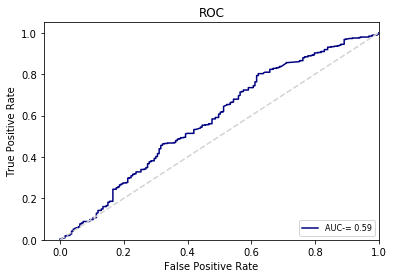

In [8]:
print ('Accuracy:',(y_test_predictions == y_testing).sum().astype(float)/(y_testing.shape[0]))
print ('Classification report:')
print (classification_report(y_testing, y_test_predictions))
print(y_testing.shape)
print(y_test_predictions.shape)
#Not sure if this is correct to map score 
#Random score
#y_score = np.random.rand(len(y_testing))
y_score = y_test_predict_probabilities[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_testing, y_score)
roc_auc = auc(false_positive_rate, true_positive_rate)
# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c='navy', label=('AUC-'+'= %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [9]:
import csv
output_list = list(zip(x_id,map(str,y_test_predictions)))
print(output_list[0])
with open('result.csv', 'w',newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    for a,b in output_list:
        wr.writerow([a,b])

('521310417696858112', '1')


In [10]:
output_list = list(zip(x_id,map(str,y_test_predictions)))
print(output_list[0])
with open('result.txt', 'w') as myfile:
    for a,b in output_list:
        myfile.writelines(f"{a}:{b}\n")

('521310417696858112', '1')
